# How to perform an arbitrary POVM on a quantum (gate based) computer




#### What is a POVM 

In quantum mechanics positive operator-valued measures (POVMs) describe the most general form of a quantum measurement. They can be used to distinguish probabilistically between non-orthogonal quantum states and are used in applications like state discrimination, quantum tomography, and qunatum encryption. 
A POVM is defined as a set of $n$ positive operators $\{\hat{E}_i\}$ that satisfy the completeness relation $ \sum_{i=1}^{n} \hat{E}_i = \hat{I}$, where $\hat{E}_i = \hat{M}_i^\dagger \hat{M}_i$ and the $\{\hat{M}_i\}$ are measurement operators. Performing a POVM on a system in initial state $|\psi_0\rangle$ results in wave function reduction to one of $n$ possible measurement outcomes $|\psi_0\rangle \rightarrow |\psi_i\rangle =\frac{\hat{M}_i|\psi_0\rangle}{\sqrt{\langle\psi_0|\hat{M}_i^{\dagger}  \hat{M}_i|\psi_0\rangle}}$, with probability $p_i = \langle\psi_0|\hat{M}_i^{\dagger}  \hat{M}_i|\psi_0\rangle$ (for more details see Nielsen and Chuang). 

#### How are POVMs implemented

In practice POVMs are either implemented by a physical hardware, specifically tailored for the task, or simulated by quantum gate operations, in some cases involving classical post-processing. 
A well known way to perform a POVM in a deterministic way, without classical post-processing is using Neumark's theorem. It states that a POVM of $n$-elements, on a target system A, can be performed by introducing an ancilla system B, with Hilbert space spanned by $n$ orthonormal basis states $|i^{(B)}\rangle$ that are in one-to-one correspondence with the POVM measurement outcomes. A unitary operation $\hat{U}_{AB}$ is then applied to the joint state of the two systems, such that
\begin{equation}\label{eq.Uab}
\hat{U}_{AB}|\psi_0^{(A)}\rangle|0^{(B)}\rangle = \sum_{i=1}^n\big[\hat{M}_{i}|\psi_0^{(A)}\rangle\big]|i^{(B)}\rangle.
\end{equation}
By performing a projective measurement on system B, system A collapses to one of the $n$ states $\hat{M}_i|\psi^{(A)}_0\rangle$ that correspond to the outcomes of the POVM.


#### Implementing Neumark's method

Based on the method, described above, we show how to perform a general $n$-element POVM on a target system consisting of a single qubit, using an ancilla system of $~ \log_2n$ qubits. To implement $\hat{U}_{AB}$, we divide it into a sequence of $(n-1)$ quantum gate circuits, which we refer to as modules. Each of these modules, except the first, will perform a general single-qubit $2$-element POVM on one of the POVM outcomes of the preceding module, and entangle the additionally produced outcome to a new state of the ancilla system.

In this notebook we will visualize this technique by implementing an example of a $3$-element single-qubit POVM, consisting of just two modules, defined by measurement operators that project on three states separated by $\frac{2 \pi}{3} rad$ in the $x-z$ plane of the Bloch sphere of the target qubit:
\begin{equation}\label{eq:M31}
\hat{M}_1=\sqrt{\frac{2}{3}}|0\rangle\langle 0|,
\end{equation}
\begin{equation}\label{eq:M32}
\hat{M}_2=\frac{1}{\sqrt{6}}\frac{|0\rangle + \sqrt{3}|1\rangle}{2}\frac{\langle0| + \sqrt{3}\langle1|}{2},
\end{equation}
\begin{equation}\label{eq:M33}
\hat{M}_3=\frac{1}{\sqrt{6}}\frac{|0\rangle - \sqrt{3}|1\rangle}{2}\frac{\langle0| - \sqrt{3}\langle1|}{2}.
\end{equation}
This POVM is a classic example considered in literature that can be used to distinguish between non-orthogonal states (for example $ |1\rangle$ and $\frac{\sqrt{3}|0\rangle+|1\rangle}{2} $). 

In [1]:
# import required libraries

from numpy import pi
import numpy as np
import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute
from qiskit.tools.visualization import circuit_drawer
from qiskit import Aer
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.visualization import plot_histogram

### Constructing a multi-qubit controlled rotation gate

Before we continue with constructing the two modules for our $3$-element POVM, we need a way to construct multi-qubit-controlled rotation gates, which will be required.
To carry out a rotation around a single axis of the Bloch sphere of a qubit $q_0$, controlled by qubits $q_1..q_m$, the rotation is decomposed to two rotations with $m-1$ control qubits as
\begin{equation}
CR_i(\theta, q_1..q_m, q_0) =  CNOT(q_1, q_0)CR_i(-\frac{\theta}{2}, q_2..q_m, q_0)CNOT(q_1, q_0)CR_i(\frac{\theta}{2}, q_2..q_m, q_0)
\end{equation}
where $i\in \{x,y,z\}$ and $CR$ stands for controlled-rotation. By decomposing each controlled rotation further, the overall operation can be brought down to $(2^m-2)$ CNOTs and $2m$ one-qubit rotations.

In the box below we present a function used to costruct a multi-qubit controlled gate.

In [2]:
def nCU1(axis, angle, q_circ, ctrls, target):
    """
        Construct a circuit for n-qubit controlled rotation
        * axis: axis of rotation (accepts values 'y' and 'z')
        * angle: angle of rotation
        * q_circ: the quantum circuit to, which the nCU1 operation is added
        * ctrls: a List or a quantum register of control qubits.
        * target: the target qubit
    """
    n_ctrls = len(ctrls)
    list_ctrls = list(ctrls)  
    new_ctrls = list_ctrls[:-1]  

    if n_ctrls == 1:
        
        if axis == 'y':
            q_circ.u3(angle, 0, 0, target)
            q_circ.cx(list_ctrls[0], target)
            q_circ.u3(-angle, 0, 0, target)
            q_circ.cx(list_ctrls[0], target)
            
        elif axis == 'z':
            q_circ.u3(0,0,angle, target)
            q_circ.cx(list_ctrls[0], target)
            q_circ.u3(0,0,-angle, target)
            q_circ.cx(list_ctrls[0], target)
            
        else:
            raise ValueError('Invalid value for axis!')
        
    elif n_ctrls >= 2:
        
        nCU1(axis, angle, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
        nCU1(axis, -angle, q_circ, new_ctrls, target)
        q_circ.cx(list_ctrls[-1], target)
        
    else:

        if axis == 'y':
            q_circ.u3(angle, 0, 0, target)
        elif axis == 'z':
            q_circ.u3(0, 0, angle, target)
        else:
            raise ValueError('Invalid value for axis!')

    return 1

### Constructing the first 2-element POVM module

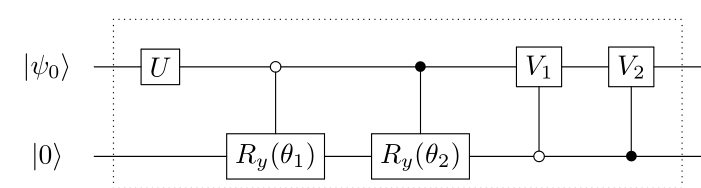

Now we proceed to construct the first of the two POVM modules. For this we need to consider one target and one ancilla qubit. For a target qubit in an arbitrary initial state $|\psi_0 \rangle = a|0\rangle + b|1\rangle$ and an ancilla qubit in $|0\rangle$ the joint system initial state is $|\Psi_0 \rangle = |\psi_0 \rangle|0\rangle $.
The module should perform a general $2$-element POVM on the state of the target qubit. This is accomplished with the circuit depicted above, which transforms the system state as

\begin{equation}\label{eq:2POVM_res}
|\Psi_0 \rangle \rightarrow |\Psi_f\rangle= \Big(\hat{V}_1\hat{D}_1\hat{U}|\psi_0\rangle\Big)|0\rangle + \Big(\hat{V}_2\hat{D}_2\hat{U} |\psi_0\rangle\Big)|1\rangle,
\end{equation}
where $\hat{D}_1 = \cos \theta_1 |0 \rangle \langle 0 | + \cos \theta_2 |1 \rangle \langle 1 |$ and
$\hat{D}_2 = \sin \theta_1 |0 \rangle \langle 0 | + \sin \theta_2 |1 \rangle \langle 1 |$. This state corresponds to the output of a general single-qubit POVM, with measurement operators $ \hat{M}_1 =\hat{V}_1 \hat{D}_1 \hat{U}$ and $\hat{M}_2 = \hat{V}_1 \hat{D}_2 \hat{U}$. 

Below we construct the circuit for the first POVM module.

In [8]:
def module_1(q_circ, q, u_y=0, u_z=0, theta1=0, theta2=0, v1_y=0, v1_z=0, v2_y=0, v2_z=0):  
    """ Constructs the circuit for the first POVM module
        q_circ: a quantun circuit object
        q: a register of at least 2 qubits.
            q[0] the target qubit 
            q[1] the ancilla qubit
        u_y, u_z, v1_y, v1_z, v2_y, v2_z: y and z rotation angles speciying single-qubit unitaries
                                          U, V1 and V2 (a general single-qubit unitary can be expsresed
                                          by a combination of an x- and y- rotation)
        theta1, theta2: angles specifying y-rotations (see diagram above)
    """
    
    # perform U
    q_circ.u3(u_y, 0, u_z, q[0])
    
    # Ry(theta1) (controlled by value 0, hence the two X gates)
    q_circ.x(q[0])
    nCU1('y', theta1, q_circ,[q[0]],q[1]) 
    q_circ.x(q[0])
    
    # Ty(theta2)
    nCU1('y', theta2, q_circ,[q[0]],q[1])
    
    #perform V1
    q_circ.x(q[1])
    nCU1('y', v1_y, q_circ,[q[1]],q[0]) 
    nCU1('z', v1_z, q_circ,[q[1]],q[0]) 
    q_circ.x(q[1])
    
    #perform V2
    nCU1('y', v2_y, q_circ,[q[1]],q[0]) 
    nCU1('z', v2_z, q_circ,[q[1]],q[0]) 


### Constructing the second 2-element POVM module


In [14]:
def module_2(q_circ, q, theta1=0, theta2=0, v1_y=0, v1_z=0, v2_y=0, v2_z=0):  
    """ Constructs the circuit for the second POVM module
    """
    
    # Ry(theta1)
    qc.x(q[0])
    nCU1('y', theta1, qc,[q[1], q[0]],q[2])
    qc.x(q[0])
    
    # Ry(theta2)
    nCU1('y', theta2,qc ,[q[1], q[0]],q[2])
  
    #perform V1
    q_circ.x(q[2])
    nCU1('y', v1_y, q_circ,[q[1], q[2]], q[0]) 
    nCU1('z', v1_z, q_circ,[q[1], q[2]], q[0]) 
    q_circ.x(q[2])
    
    #perform V2
    nCU1('y', v2_y, q_circ,[q[1], q[2]], q[0]) 
    nCU1('z', v2_z, q_circ,[q[1], q[2]], q[0]) 

In [10]:
# angle parameters for the 1st and 2nd panel
theta1 = np.arccos(np.sqrt(2/3))
theta2 = pi/2
theta3=0
theta4 = pi/2

# Ui and Uii are implemented as controled rotations as well. 
# In our example Ui = I, so no action needed
# For Uii required y rotation at -pi/2 rads 

alpha_uii = -pi/2

In [15]:
# Create a Quantum Register with 3 qubits.
q = QuantumRegister(3, 'q')

# Create a Quantum Circuit acting on the q register
qc = QuantumCircuit(q)

# Apply the 1st 
module_1(qc,q,theta1=theta1,theta2=theta2, v2_y=alpha_uii)

module_2(qc,q, theta2=theta4, v1_y=2*pi/3, v2_y=7*pi/3)

In [11]:
from qiskit import IBMQ
# IBMQ.save_account("token")
# IBMQ.update_account()
IBMQ.load_account()
# IBMQ.stored_accounts()

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

At this point we have obtained the desired POVMs $F_1, F_2$ and $F_3$. However they do not completerly define the measurement operators $ M_1, M_2 $ and $ M_3 $. To fully specify the measurements we need to perform $ T_1 , T_2, T_3 $ unitary operations to each of the 3 outputs. 

In the case of three measurements corresponding to axes $ 120^o$ apart, one of which is along the $z_+$ axis we need to perform the following T operations:

(this is wrong)

$ T_1 = I = \left( \begin{smallmatrix} 1&0\\ 0&1 \end{smallmatrix} \right)$ , $ T_2 = \frac{1}{2} \left( \begin{smallmatrix} 1& -\sqrt{3}\\ \sqrt{3}&1 \end{smallmatrix} \right)$,  $ T_3 = \frac{1}{2} \left( \begin{smallmatrix} 1& \sqrt{3}\\ -\sqrt{3}&1 \end{smallmatrix} \right)$ 

To perform this operations we use our n-qubit controled rotation. We perform y-axis rotation at angles $ 0 ,\frac{2\pi}{3}, \frac{-2\pi}{3} $ respectevely, with control qubits $ { q_1, q_2 } $ and target qubit $ q_0 $. Again we use X gates to tackle the values of the control qubits. 


In [16]:
# Add Measurements

# Create a Classical Register with 3 bits.
c = ClassicalRegister(3, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = qc+meas

circuit_drawer(qc)

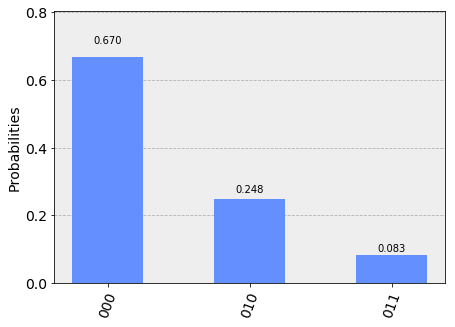

In [17]:
# Run the quantum circuit on a simulator backend
backend = Aer.get_backend('qasm_simulator')
shots = 8192

# Create a Quantum Program for execution 
job = execute(qc, backend, shots = shots)

# execute
result = job.result()

counts = result.get_counts(qc)
plot_histogram(counts)

In [16]:
# IBMQ.save_account(token)
IBMQ.load_account()


shots = 8192           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 10       # Maximum number of credits to spend on executions. 
n_qubits = 3


# large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration()['n_qubits'] >= n_qubits and
#                                                        not x.configuration()['simulator'])
# backend = least_busy(large_enough_devices)
backend = IBMQ.backends(name = 'ibmqx2')[0]
print("The best backend is " + backend.name())

/home/jordan/workspace/qiskit/qiskit_venv/lib/python3.6/site-packages/qiskit/providers/ibmq/ibmqfactory.py:547: DeprecationWarning: IBMQ.backends() is being deprecated. Please use IBMQ.get_provider() to retrieve a provider and AccountProvider.backends() to find its backends.
  DeprecationWarning)


The best backend is ibmqx2


In [17]:
# Hello there
# <<<<<<<<<<< EXECUTING real experiment >>>>>>>>>>>>>>
run = 1  # keep 0 untill you want to run the experiment, to avoid running by mistake. It is slow and cost credits!
if run:
    job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
    result = job_exp.result()

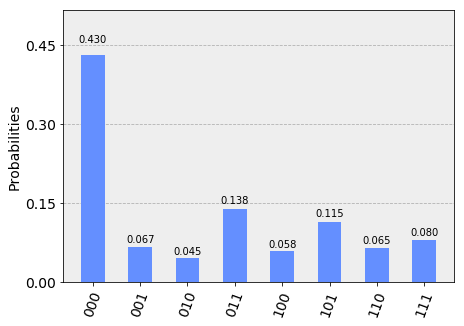

In [18]:
counts = result.get_counts(qc)
plot_histogram(counts)

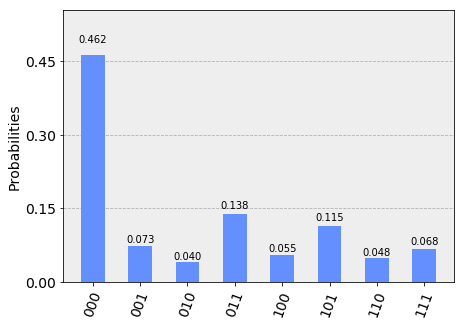

In [12]:
#ibmqx2